<a href="https://colab.research.google.com/github/AcqmalFadhilla/image-classification-using-CNN/blob/main/submission_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import tensorflow as tf
import pathlib

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D

In [4]:
local_zip = "/content/rice-image-dataset.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/content")
zip_ref.close()

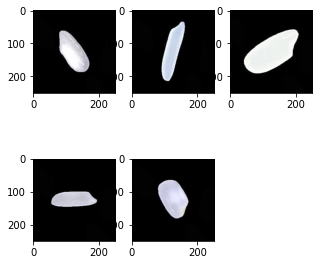

In [5]:
img_arborio = plt.imread("/content/Rice_Image_Dataset/Arborio/Arborio (10).jpg")
img_basmati = plt.imread("/content/Rice_Image_Dataset/Basmati/Basmati (1).jpg")
img_ipsala = plt.imread("/content/Rice_Image_Dataset/Ipsala/Ipsala (10).jpg")
img_jasmine = plt.imread("/content/Rice_Image_Dataset/Jasmine/Jasmine (1).jpg")
img_karacag = plt.imread("/content/Rice_Image_Dataset/Karacadag/Karacadag (1).jpg")

image = [img_arborio, img_basmati, img_ipsala, img_jasmine, img_karacag]
fig = plt.figure(figsize =(5, 5))
rows = 2
col = 3
for j in range(0, rows+col):
  plt.subplot(rows, col, j+1)
  plt.imshow(image[j])


In [6]:
root_path = "/content/Rice_Image_Dataset/"
class_names = sorted(os.listdir(root_path))[:-1]
size = [len(os.listdir(root_path + name)) for name in class_names]
     
fig = px.pie(names=class_names, values=size)
fig.show()

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    validation_split=0.2,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    root_path,
    target_size=(150, 150),
    batch_size=32,
    shuffle=True,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    root_path,
    target_size=(150, 150),
    batch_size=32,
    shuffle=True,
    class_mode="categorical",
    subset="validation"
)

Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


In [8]:
model = tf.keras.Sequential([
      Conv2D(64,kernel_size=5,strides=2,padding='valid',activation='relu',input_shape=(256,256,3)), 
      BatchNormalization(),
      MaxPooling2D(),
      Conv2D(128,kernel_size=3,strides=1,padding='same',activation='relu'), 
      Conv2D(128,kernel_size=3,strides=1,padding='same',activation='relu'), 
      BatchNormalization(),
      MaxPooling2D(),
      Conv2D(256,kernel_size=5,strides=2,padding='same',activation='relu'), 
      Conv2D(256,kernel_size=5,strides=2,padding='same',activation='relu'), 
      GlobalAveragePooling2D(),
      Dense(256,activation='relu'),
      Dense(164,activation='relu'),
      Dense(5,activation='softmax'),
  ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      4864      
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 128)       147584    
                                                                 
 batch_normalization_1 (Batc  (None, 63, 63, 128)      5

In [9]:
model.compile(
       loss='categorical_crossentropy',
       optimizer='adam',
       metrics=['accuracy']
   )

In [10]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get("accuracy") > 0.95):
      print("akurasi telah mencapai 95%")
      self.model.stop_training = True
callback = myCallback()

In [11]:
history = model.fit(train_generator, shuffle=True, epochs=50, batch_size=32, 
                    validation_data=(val_generator), callbacks=[callback])

Epoch 1/50
1875/1875 [==============================] - 449s 233ms/step - loss: 0.2336 - accuracy: 0.9109 - val_loss: 1.5497 - val_accuracy: 0.5199
Epoch 2/50
1875/1875 [==============================] - 427s 228ms/step - loss: 0.0712 - accuracy: 0.9759 - val_loss: 0.1152 - val_accuracy: 0.9555


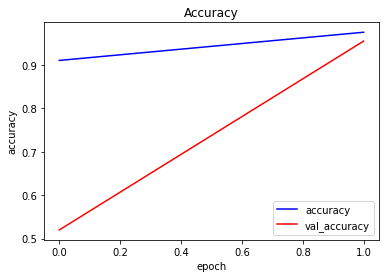

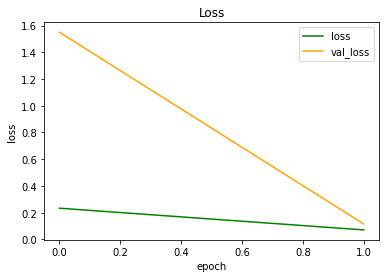

In [13]:
accuracy = history.history["accuracy"]
loss = history.history["loss"]
val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

plt.plot(accuracy, label="accuracy", color="blue")
plt.plot(val_accuracy, label="val_accuracy", color="red")
plt.title("Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc="lower right")
plt.show()

plt.plot(loss, label="loss", color="green")
plt.plot(val_loss, label="val_loss", color="orange")
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc="upper right")
plt.show()

In [16]:
save_path = "my_model/"
tf.saved_model.save(model, save_path)

In [24]:
converter = tf.lite.TFLiteConverter.from_saved_model(save_path)
tflite_model = converter.convert()

with tf.io.gfile.GFile('my_model.tflite', 'wb') as f:
    f.write(tflite_model)